# Homework07

Exercises to practice pandas, data analysis and regression

## Goals

- Understand the effects of pre-processing data
- Get familiar with the ML flow: encode -> normalize -> train -> evaluate
- Understand the difference between regression and classification tasks
- Build intuition for different regression models

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [10]:
!wget -q https://github.com/PSAM-5020-2025F-A/5020-utils/raw/main/src/data_utils.py

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor

from data_utils import object_from_json_url
from data_utils import regression_error

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/DM-GY-9103-2024F-H/WK02).

This is the dataset that has anthropometric information about U.S. Army personnel.

#### WARNING

Like we mentioned in class, this dataset is being used for these exercises due to the level of detail in the dataset and the rigorous process that was used in collecting the data.

This is a very specific dataset and should not be used to draw general conclusions about people, bodies, or anything else that is not related to the distribution of physical features of U.S. Army personnel.

In [12]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025F-A/5020-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

#### Nested data

This is that *nested* dataset from Week 02.

# 🤔

Let's load it into a `DataFrame` to see what happens.

In [13]:
# Read into DataFrame
ansur_df = pd.DataFrame.from_records(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear,foot,hand,head
0,18,F,66,135,1699,1645,"{'breadth': 30, 'length': 61, 'protrusion': 20}","{'breadth': 97, 'length': 243}","{'breadth': 78, 'length': 182, 'palm': 108}","{'height': 243, 'circumference': 557}"
1,30,M,68,207,1749,1715,"{'breadth': 35, 'length': 63, 'protrusion': 17}","{'breadth': 100, 'length': 252}","{'breadth': 87, 'length': 184, 'palm': 114}","{'height': 238, 'circumference': 560}"
2,27,M,67,121,1684,1657,"{'breadth': 36, 'length': 59, 'protrusion': 24}","{'breadth': 92, 'length': 251}","{'breadth': 84, 'length': 180, 'palm': 103}","{'height': 239, 'circumference': 516}"
3,20,M,73,185,1878,1828,"{'breadth': 36, 'length': 60, 'protrusion': 21}","{'breadth': 104, 'length': 280}","{'breadth': 95, 'length': 201, 'palm': 124}","{'height': 270, 'circumference': 582}"
4,33,M,76,150,1977,1883,"{'breadth': 39, 'length': 65, 'protrusion': 27}","{'breadth': 101, 'length': 271}","{'breadth': 90, 'length': 194, 'palm': 113}","{'height': 254, 'circumference': 559}"



# 😓🙄

That didn't work too well. We ended up with objects in our columns.

Luckily, our `DataFrame` library has a function called [`json_normalize()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) that can help.

In [14]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


Much better. `DataFrames` are magic.

#### Data Exploration

Before we start creating models, let's do a little bit of data analysis and get a feeling for the shapes, distributions and relationships of our data.

1. Print `min`, `max` and `average` values for all of the features.
2. Print `covariance` tables for `age`, `ear.length` and `head.circumference`.
3. Plot `age`, `ear.length` and `head.circumference` versus the $1$ *feature* that is most correlated to each of them.

Don't forget to *encode* and *normalize* the data.

,age,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference,F,M
age,1.000179,0.029467,0.217017,0.064304,0.037972,0.187740,0.292098,-0.009254,0.064993,0.048699,0.133830,0.104642,0.120726,0.038637,0.014044,-0.062201,0.062201
height,0.029467,1.000179,0.659590,0.869103,0.959988,0.355310,0.421910,0.283853,0.662081,0.820186,0.712196,0.736264,0.695159,0.554231,0.439234,-0.656634,0.656634
weight,0.217017,0.659590,1.000179,0.662828,0.682587,0.361981,0.487481,0.242281,0.708759,0.688228,0.710663,0.599894,0.591608,0.521809,0.540160,-0.562369,0.562369
span,0.064304,0.869103,0.662828,1.000179,0.899400,0.348283,0.401564,0.268229,0.681016,0.862806,0.731574,0.844382,0.796280,0.536677,0.476903,-0.648306,0.648306
stature,0.037972,0.959988,0.682587,0.899400,1.000179,0.365847,0.438604,0.289324,0.677517,0.844233,0.727613,0.761877,0.720473,0.577022,0.462999,-0.663334,0.663334
ear.breadth,0.187740,0.355310,0.361981,0.348283,0.365847,1.000179,0.454968,0.240675,0.367536,0.385165,0.415684,0.341742,0.293001,0.277395,0.221058,-0.410499,0.410499
ear.length,0.292098,0.421910,0.487481,0.401564,0.438604,0.454968,1.000179,0.382646,0.436241,0.419030,0.465829,0.335176,0.341726,0.384718,0.283878,-0.463540,0.463540
ear.protrusion,-0.009254,0.283853,0.242281,0.268229,0.289324,0.240675,0.382646,1.000179,0.294336,0.279865,0.316847,0.194417,0.204587,0.273468,0.124790,-0.413054,0.413054
foot.breadth,0.064993,0.662081,0.708759,0.681016,0.677517,0.367536,0.436241,0.294336,1.000179,0.759427,0.789143,0.661091,0.639648,0.547463,0.492590,-0.641221,0.641221
foot.length,0.048699,0.820186,0.688228,0.862806,0.844233,0.385165,0.419030,0.279865,0.759427,1.000179,0.770189,0.842393,0.797695,0.574766,0.501324,-0.669078,0.669078


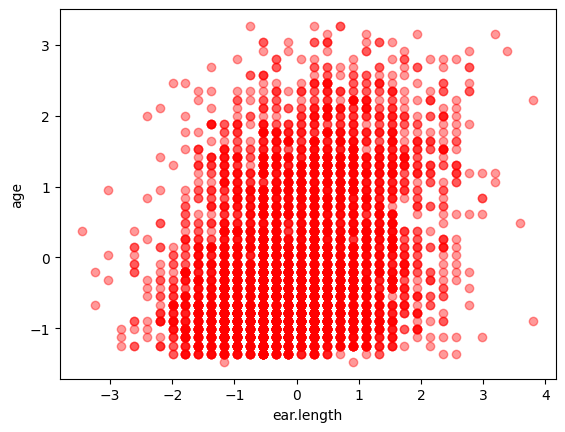

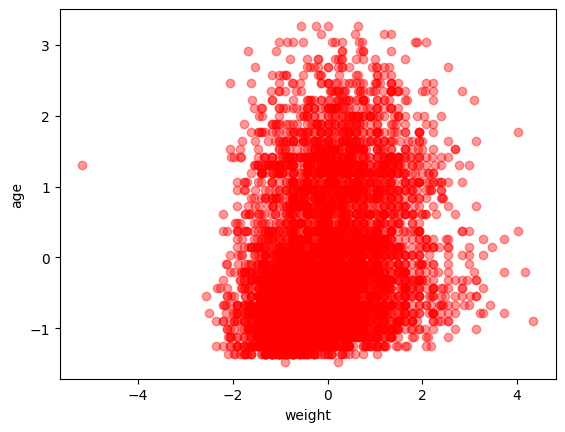

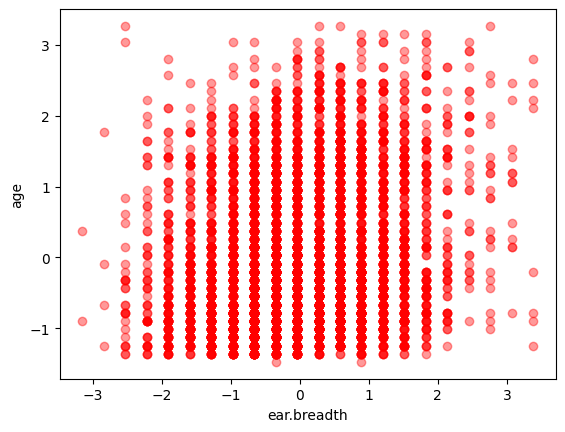

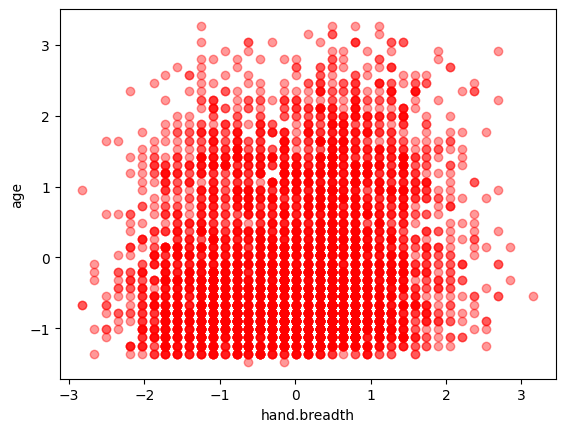

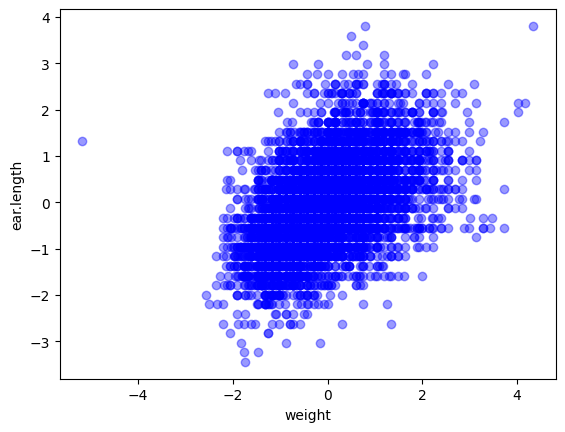

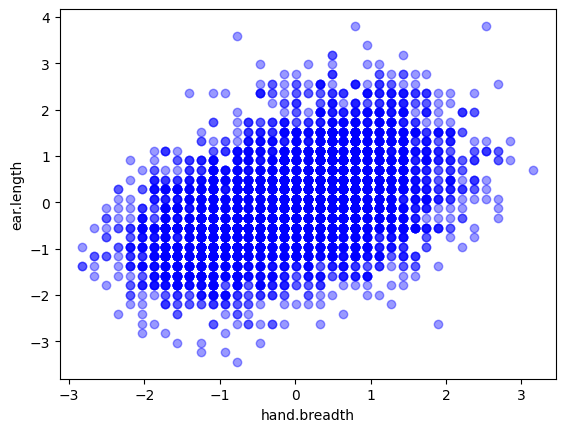

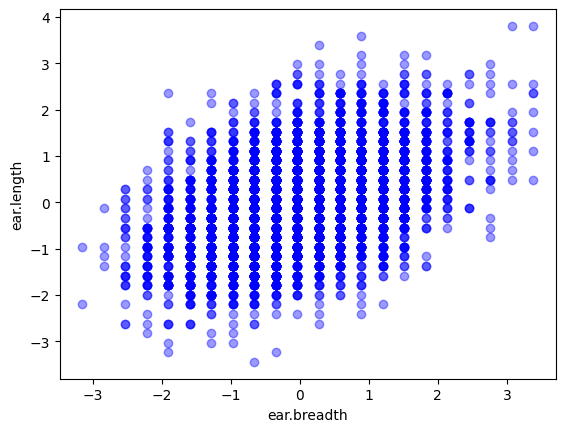

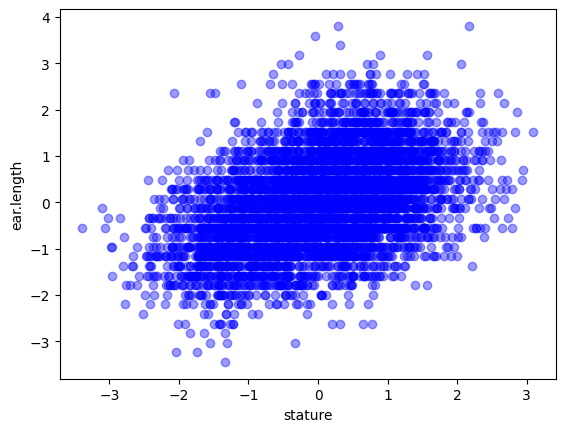

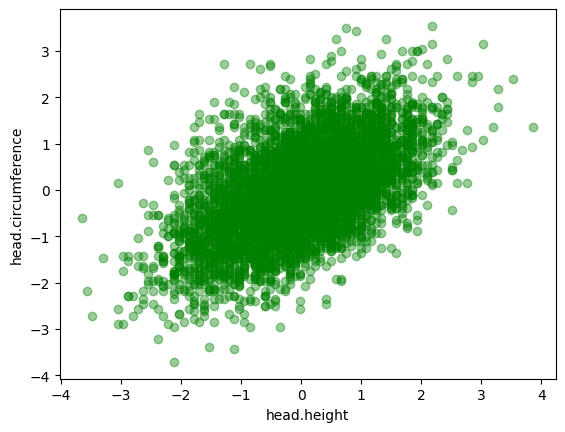

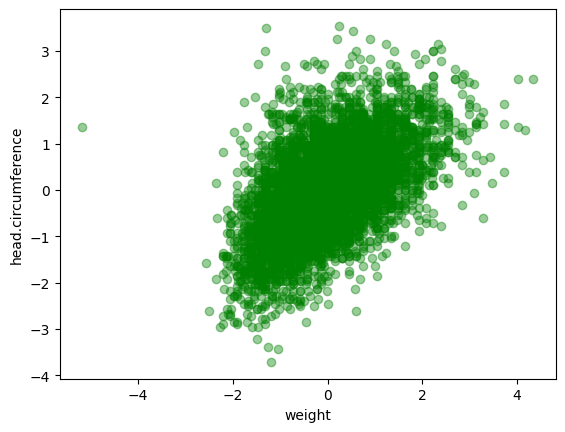

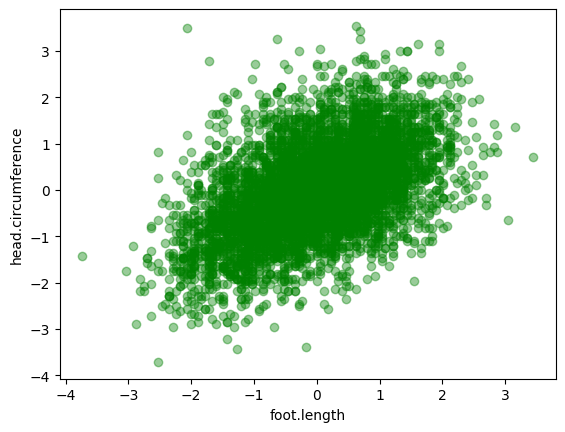

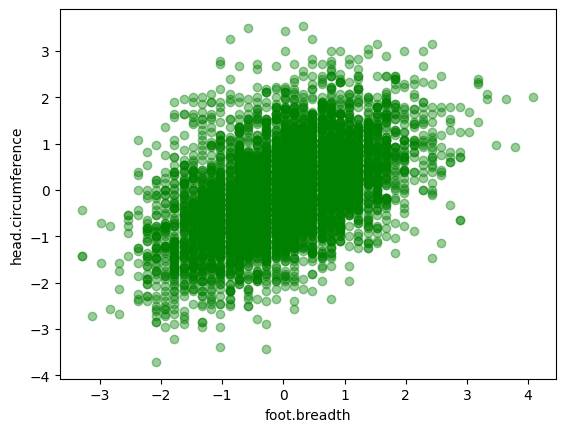

In [15]:
# Work on Data Exploration here

### Encode non-numerical features
# gender is non-numerical and has two possible values: F and M
# since the values don't have an order, we can use OneHotEncoder, which turns each value into a distinct feature and uses 0 and 1 to mark whether a record has a value or not

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
gender_encoded = encoder.fit_transform(ansur_df[['gender']])
# getting the new column names
# since encoder.categories creates a list of arrays (one array per feature), we access the first element of the list
new_col_names = encoder.categories_[0]
ansur_encoded_gender_df = pd.DataFrame(gender_encoded, columns=new_col_names, index=ansur_df.index)

# concatenating the new columns to the original dataframe and dropping the original gender column
ansur_encoded_df = pd.concat([ansur_df, ansur_encoded_gender_df], axis=1)
ansur_encoded_df = ansur_encoded_df.drop(columns=['gender'])

# checking the new dataframe and confirming is has been encoded correctly
# print(ansur_encoded_df.head())


## 1. Print min, max, avg
max_values = ansur_encoded_df.max()
min_values = ansur_encoded_df.min()
avg_values = ansur_encoded_df.mean()
# print("max values are:\n", max_values)
# print("min values are:\n", min_values)
# print("avg values are:\n", avg_values)

### Normalize all data
# using StandardScaler, to represent each data point in terms of the aggregate characteristics for that collection of points
scaler = StandardScaler().set_output(transform="pandas")
ansur_scaled_df = scaler.fit_transform(ansur_encoded_df)

## 2. Print Covariances
display(ansur_scaled_df.cov())

## 3. Plot features most correlated to age, ear length and head circumference
# features most correlated to age are ear.length, weight, ear.breadth, and hand.breadth
# ear.length has strong correlation with different features: weight, hand.breadth, ear.breadth, stature, etc
# the same applies to head circumference, with head.height, weight, foot.length	, and foot.breadth being the most correlated features

# plot age as a function of ear.length, weight, ear.breadth, and hand.breadth
for feat in ["ear.length", "weight", "ear.breadth", "hand.breadth"]:
  plt.plot(ansur_scaled_df[feat], ansur_scaled_df["age"], marker="o", color="r", linestyle="", alpha=0.4)
  plt.xlabel(feat)
  plt.ylabel("age")
  plt.show()

# plot ear.length as a function of weight, hand.breadth, ear.breadth, stature
for feat in ["weight", "hand.breadth", "ear.breadth", "stature"]:
  plt.plot(ansur_scaled_df[feat], ansur_scaled_df["ear.length"], marker="o", color="b", linestyle="", alpha=0.4)
  plt.xlabel(feat)
  plt.ylabel("ear.length")
  plt.show()
# these plots show a stronger, more discernible positive correlation between ear.length and the other features

# plot head.circumference as a function of head.height, weight, foot.length, and foot.breadth
for feat in ["head.height", "weight", "foot.length", "foot.breadth"]:
  plt.plot(ansur_scaled_df[feat], ansur_scaled_df["head.circumference"], marker="o", color="g", linestyle="", alpha=0.4)
  plt.xlabel(feat)
  plt.ylabel("head.circumference")
  plt.show()
# these plots also show a strong positive correlation between head.circumference and the other features



### Interpretation

<span style="color:hotpink;">
Does anything stand out about these graphs? Or the correlations?<br>
Are correlations symmetric? Does the feature most correlated to ear length also have ear length as its most correlated pair?
</span>

The plots for age should show a positive correlation between age and the other features, but the correlation is subtle so it's almost visually undiscernible in all cases except for ear.length, which shows a more pronounced positive correlation.

In contrast, the plots for ear.length and head.circumference show a clearer, strong correlation between the variables and the respective correlated features.
Overall, this suggests that age is not the stronger indicator when it comes to predicting the vaues for other features.

Correlations are symmetric, meaning that the correlation between variable X and variable Y is identical to the correlation between variable Y and variable X. But this does not mean that the feature most correlated with a variable also has to have that variable as its most correlated pais. For example, the feature with which ear.length has the strongest correlation is weight. But weight shows more correlation with several other values than with ear.length, such as hand.breadth, foot.breadth, foot.length, and stature.

### Regression

Now, we want to create a regression model to predict `head.circumference` from the data.

From our [Week 07](https://github.com/PSAM-5020-2025F-A/WK07) notebook, we can create a regression model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (done! ⚡️)
3. Normalize the data (done! 🍾)
4. Separate the outcome variable and the input features
5. Create a regression model using all features
6. Run model on training data and measure error
7. Plot predictions and interpret results
8. Run model on test data, measure error, plot predictions, interpret results

error on training data: 0.7779232106405695


/tmp/ipykernel_1758/3200169971.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


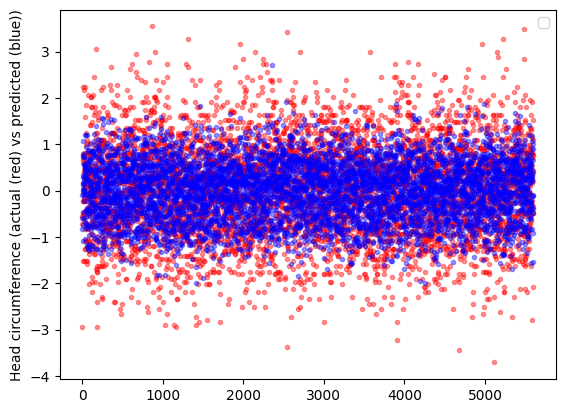

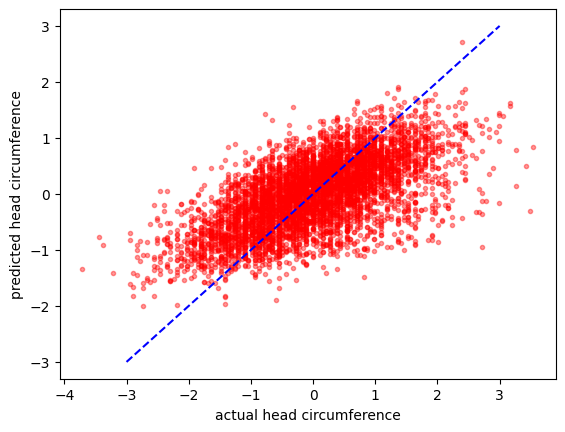

In [21]:
# Work on Regression Model here

## Separate outcome variable and input features
head_circumference = ansur_scaled_df[["head.circumference"]]
features = ansur_scaled_df[["head.height", "weight", "foot.length", "foot.breadth"]]

## Create a regression model
head_circumference_model = LinearRegression().fit(features, head_circumference)

## Measure error on training data
predicted_head_circumference = head_circumference_model.predict(features)
error = regression_error(head_circumference, predicted_head_circumference)
print("error on training data:", error)

## Plot predictions and interpret results

plt.plot(head_circumference, color='r', marker='o', markersize='3', linestyle='', alpha=0.4)
plt.plot(predicted_head_circumference, color='b', marker='o', markersize='3', linestyle='', alpha=0.4)
plt.ylabel("Head circumference (actual (red) vs predicted (blue))")
plt.legend()
plt.show()

# another way of seeing this would be to plot predicted vs actual in comparison to what would be perfect predictions
plt.plot(head_circumference, predicted_head_circumference, color='r', marker='o', markersize='3', linestyle='', alpha=0.4)
plt.xlabel("actual head circumference")
plt.ylabel("predicted head circumference")
# diagonal line to indicate perfect predictions
plt.plot([-3, 3], [-3, 3], color='b', linestyle='--')
plt.show()


In [ ]:
## Load Test Data
ANSUR_TEST_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025F-A/5020-utils/main/datasets/json/ansur-test.json"

ansur_test_data = object_from_json_url(ANSUR_TEST_FILE)
ansur_test_df = pd.json_normalize(ansur_test_data)

ansur_test_encoded_df = ansur_test_df.copy()

g_vals = ansur_encoder.transform(ansur_test_df[["gender"]].values)
ansur_test_encoded_df[["gender"]] = g_vals

ansur_test_scaled_df = ansur_scaler.transform(ansur_test_encoded_df)

In [ ]:
## Run model on test data

## Measure error on test data

## Plot predictions and interpret results

### Interpretation

<span style="color:hotpink;">
How well does your model perform?<br>
How could you improve it?<br>
Are there ranges of circumferences that don't get predicted well?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>